### Описание задачи

Для оптимизации производственных расходов, необходимо уменьшить потребление электроэнергии на этапе обработки стали.

Описание процесса

Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. При каждом цикле производится измерение температуры расплава.

Необходимо построить модель, которая предскажет температуру стали.

Для оценки качества модели используется метрика MAE.

## Загрузка и обработка данных

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import xgboost as xg
from sklearn.model_selection import GridSearchCV

### data_arc

In [6]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [7]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [8]:
data_arc = data_arc.rename( 
 columns={ 
    'Начало нагрева дугой':'start_time',  
    'Конец нагрева дугой':'end_time',
    'Активная мощность': 'active_power', 
    'Реактивная мощность': 'reactive_power'
 } 
)

In [9]:
data_arc['start_time'] = pd.to_datetime(data_arc['start_time'], yearfirst = True)
data_arc['end_time'] = pd.to_datetime(data_arc['end_time'], yearfirst = True)

In [10]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_time      14876 non-null  datetime64[ns]
 2   end_time        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


### data_bulk_time

In [12]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [13]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [14]:
# т.к. в таблице data_bulk_time содержится информация о подаче сыпучих материалов, 
# то пропуски в данных означают отсутствие добавок, пропуски будут заменены на 0
data_bulk_time = data_bulk_time.fillna(0) 

In [15]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   3129 non-null   object
 2   Bulk 2   3129 non-null   object
 3   Bulk 3   3129 non-null   object
 4   Bulk 4   3129 non-null   object
 5   Bulk 5   3129 non-null   object
 6   Bulk 6   3129 non-null   object
 7   Bulk 7   3129 non-null   object
 8   Bulk 8   3129 non-null   object
 9   Bulk 9   3129 non-null   object
 10  Bulk 10  3129 non-null   object
 11  Bulk 11  3129 non-null   object
 12  Bulk 12  3129 non-null   object
 13  Bulk 13  3129 non-null   object
 14  Bulk 14  3129 non-null   object
 15  Bulk 15  3129 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


### data_bulk

In [17]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [18]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [19]:
# т.к. в таблице data_bulk_time содержится информация о подаче сыпучих материалов, 
# то пропуски в данных означают отсутствие добавок, пропуски будут заменены на 0
data_bulk = data_bulk.fillna(0) 

In [20]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


### data_gas

In [22]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [23]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [24]:
data_gas = data_gas.rename( 
 columns={ 
'Газ 1': 'gas'
 } 
)

### data_temp

In [26]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [27]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [28]:
data_temp = data_temp.rename( 
 columns={ 
'Время замера': 'time', 
'Температура': 'temperature'
 } 
)

In [29]:
data_temp['time'] = pd.to_datetime(data_temp['time'], yearfirst = True)

In [30]:
data_temp[data_temp['temperature'].isna()].sort_values(by='key')

,key,time,temperature
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15897,3240,2019-09-01 03:12:19,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15903,3241,2019-09-01 04:16:12,NaN


In [31]:
# установка заглушки
data_temp['temperature'] = data_temp['temperature'].fillna(-10000) 

In [32]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          15907 non-null  int64         
 1   time         15907 non-null  datetime64[ns]
 2   temperature  15907 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


### data_wire_time

In [34]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [36]:
# т.к. в таблице data_wire_time содержится информация о проволочных материалах, 
# то пропуски в данных означают отсутствие добавок, пропуски будут заменены на 0
data_wire_time = data_wire_time.fillna(0) 

In [37]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3081 non-null   object
 2   Wire 2  3081 non-null   object
 3   Wire 3  3081 non-null   object
 4   Wire 4  3081 non-null   object
 5   Wire 5  3081 non-null   object
 6   Wire 6  3081 non-null   object
 7   Wire 7  3081 non-null   object
 8   Wire 8  3081 non-null   object
 9   Wire 9  3081 non-null   object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


### data_wire

In [39]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [41]:
# т.к. в таблице data_wire содержится информация о подаче сыпучих материалов, 
# то пропуски в данных означают отсутствие добавок, пропуски будут заменены на 0
data_wire = data_wire.fillna(0) 

In [42]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


### Вывод:
- были загружены данные из таблиц: data_arc.csv, data_bulk.csv, data_bulk_time.csv, data_gas.csv, data_temp.csv, data_wire.csv, data_wire_time.csv
- в таблице data_arc столбцы 'Начало нагрева дугой' и 'Конец нагрева дугой' были приведенеы к типу datetime, пропуски данных отсутствуют, названия столбцов приведены к змеиному регистру
- в таблице data_bulk_time пропуски были заменеы на 0, так как остуствие информации в столбцах говорит, что добавки не были введены
- в таблице data_bulk пропуски были заменеы на 0, так как остуствие информации в столбцах говорит, что добавки не были введены
- в таблице data_gas названия столбцов приведены к змеиному регистру, пропуски данных отсутствуют
- в таблице data_temp названия столбцов приведены к змеиному регистру, в столбце time изменен тип данных на datetime, пропуски в столбце temperature установлена заглушка -10000
- в таблице data_wire_time пропуски были заменеы на 0, так как остуствие информации в столбцах говорит, что добавки не были введены
- в таблице data_wire пропуски были заменеы на 0, так как остуствие информации в столбцах говорит, что добавки не были введены

## Анализ данных

### data_arc

In [43]:
# суммарные значения мощности по столбцу key
data_arc_grouped = data_arc.groupby('key').sum()

In [44]:
data_arc_grouped.describe()

,active_power,reactive_power
count,3214.000000,3214.000000
mean,3.103138,2.094821
std,1.397390,12.689508
min,0.186226,-714.591636
25%,2.126339,1.599018
50%,2.990537,2.229869
75%,3.901147,2.899141
max,17.496497,12.587990


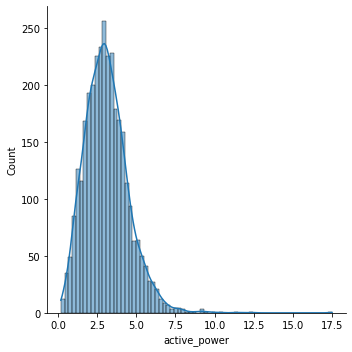

In [45]:
sns.displot(data_arc_grouped.active_power,kde=True);

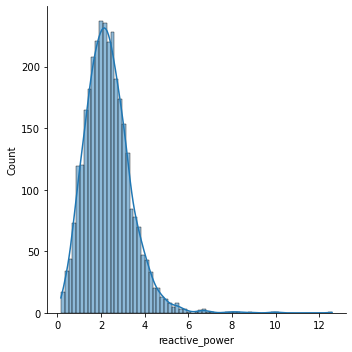

In [46]:
sns.displot(data_arc_grouped.query('reactive_power>0')['reactive_power'],kde=True);

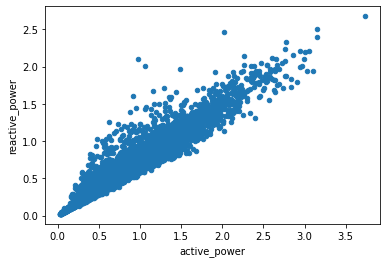

In [47]:
data_arc.query('reactive_power>0').plot(x='active_power', y='reactive_power', kind='scatter');

### data_bulk

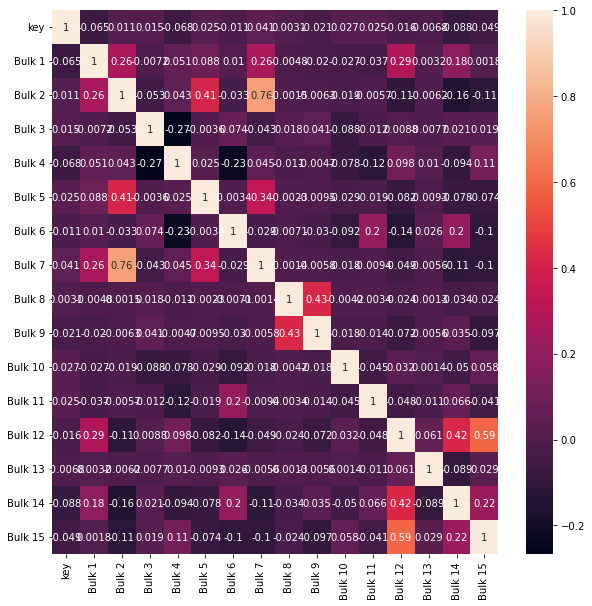

In [48]:
corr=data_bulk.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot =True);

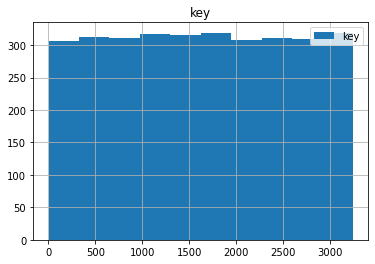

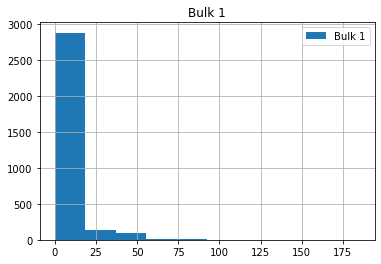

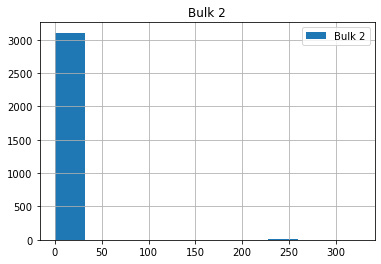

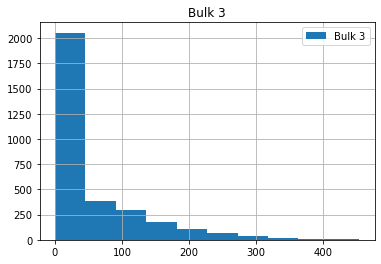

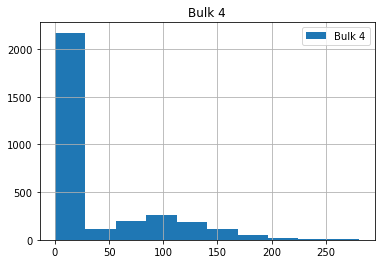

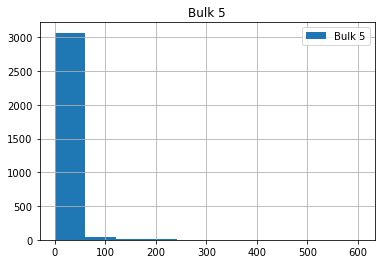

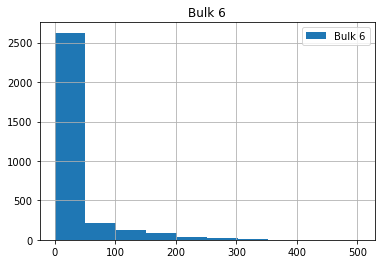

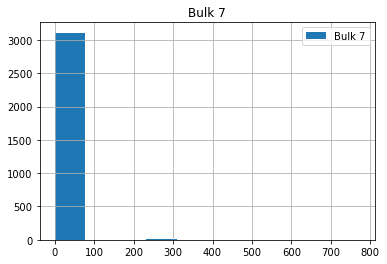

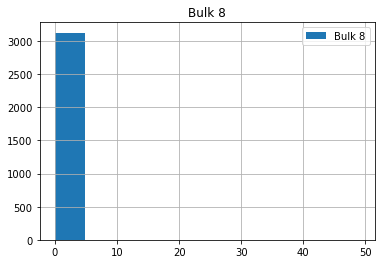

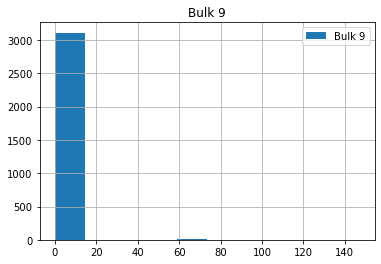

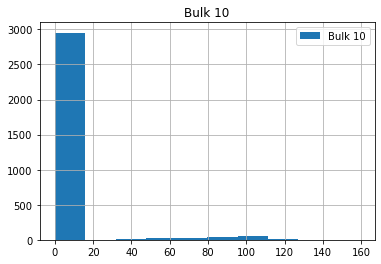

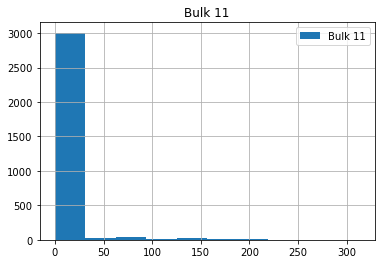

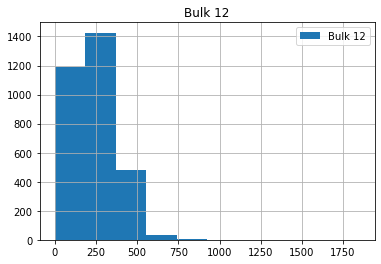

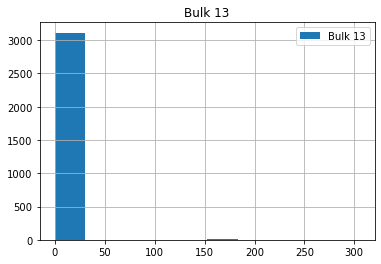

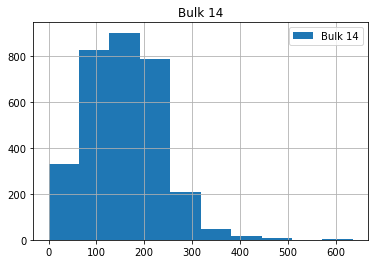

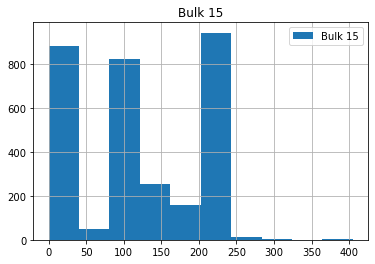

In [49]:
for column in data_bulk:
    data_bulk.hist(column = column, legend=True);
    plt.show()

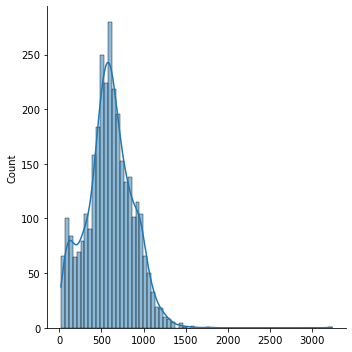

In [50]:
sns.displot(data_bulk.loc[:, 'Bulk 1':'Bulk 15'].sum(axis=1),kde=True);

### data_temp

In [51]:
# сортировка по key и времени
data_temp = data_temp.sort_values(by='key').sort_values(by='time') 

In [52]:
#начальное значение температуры
data_temp_first = data_temp.drop_duplicates(subset='key', keep='first', ignore_index=True)

In [53]:
#конечное значение температуры
data_temp_last = data_temp.drop_duplicates(subset='key', keep='last', ignore_index=True)

In [54]:
# проверка наличия заглушек в получ данных
display(data_temp_first.query('temperature<0'))
display(data_temp_last.query('temperature<0'))

,key,time,temperature


,key,time,temperature
2477,2500,2019-08-06 03:28:21,-10000.0
2478,2501,2019-08-06 04:31:14,-10000.0
2479,2502,2019-08-06 05:12:20,-10000.0
2480,2503,2019-08-06 06:07:35,-10000.0
2481,2504,2019-08-06 07:04:16,-10000.0
...,...,...,...
3211,3237,2019-08-31 23:05:43,-10000.0
3212,3238,2019-08-31 23:43:00,-10000.0
3213,3239,2019-09-01 02:24:15,-10000.0
3214,3240,2019-09-01 03:35:16,-10000.0


In [55]:
#удаление строк с заглушками
data_temp_last = data_temp_last.query('temperature>0')

In [56]:
#дельта между нач и кон значениями темп
data_temp_joined = data_temp_first.merge(data_temp_last, on='key', how='inner')
data_temp_joined['delta'] = data_temp_joined['temperature_y']-data_temp_joined['temperature_x']

In [57]:
data_temp_joined['time'] = data_temp_joined['time_y']-data_temp_joined['time_x']

In [58]:
data_temp_joined['time'] = data_temp_joined['time'].dt.total_seconds()

In [59]:
data_temp_joined = data_temp_joined[['key','temperature_y','delta','time']].reset_index()

<AxesSubplot:>

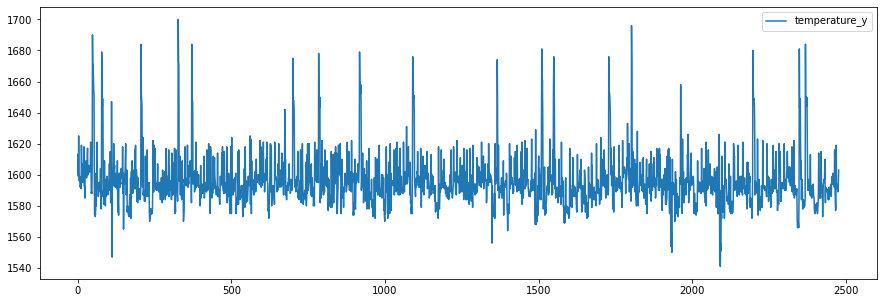

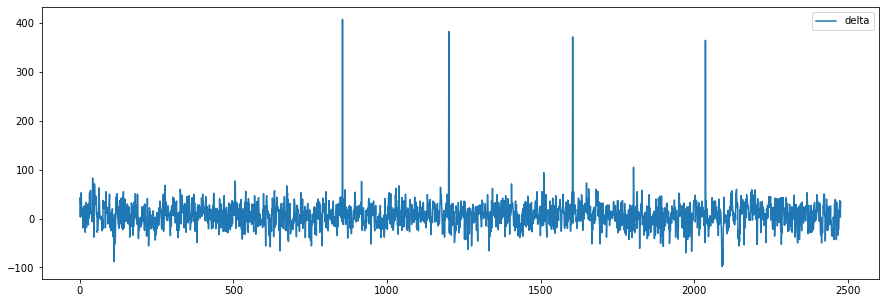

In [60]:
data_temp_joined.plot(y='temperature_y', figsize = (15,5))
data_temp_joined.plot(y='delta', figsize = (15,5))

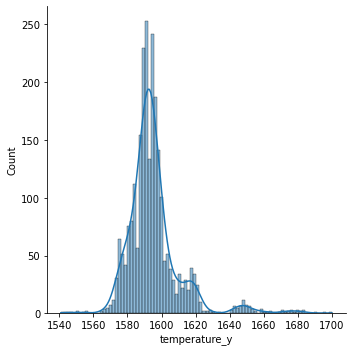

In [61]:
sns.displot(data_temp_joined.temperature_y,kde=True);

### data_gas

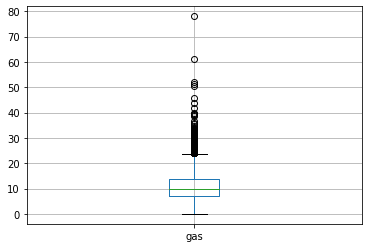

In [62]:
data_gas.boxplot(column='gas');

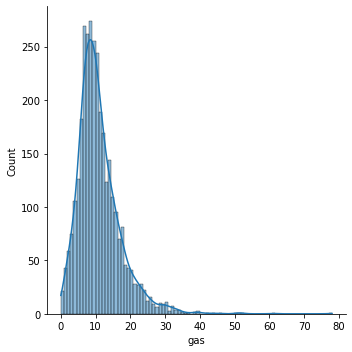

In [63]:
sns.displot(data_gas.gas, kde=True);

### data_wire

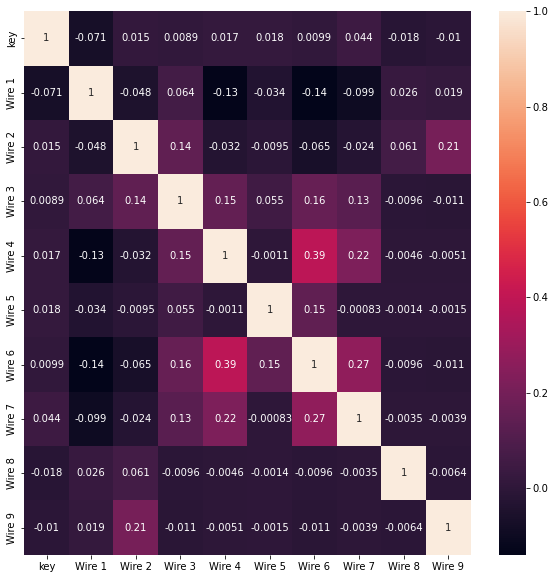

In [64]:
corr=data_wire.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True);

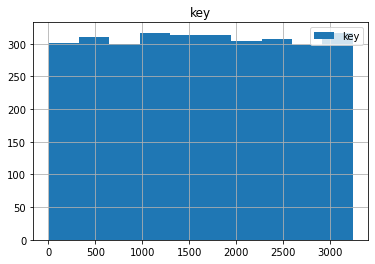

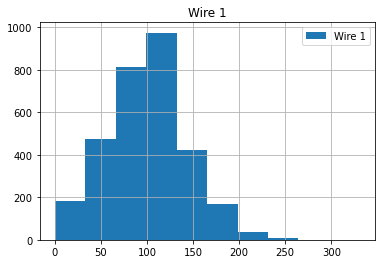

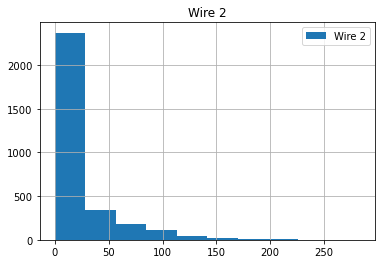

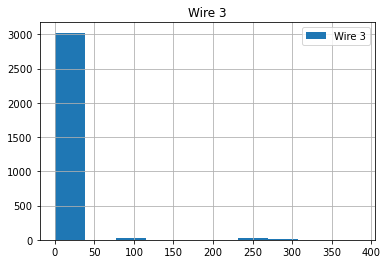

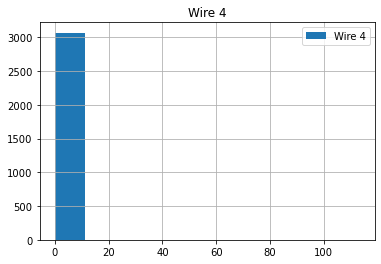

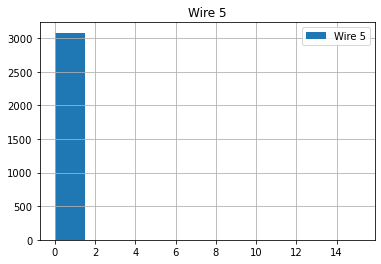

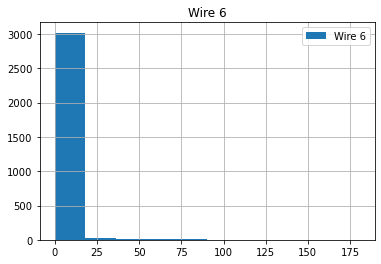

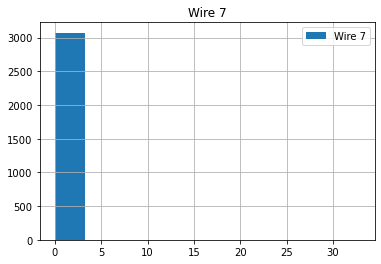

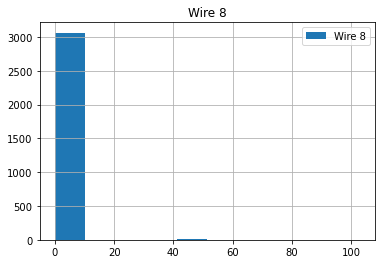

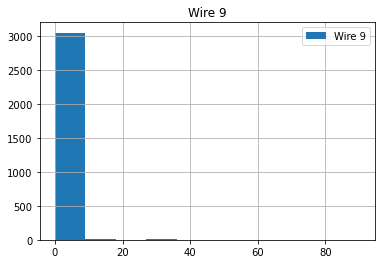

In [65]:
for column in data_wire:
    data_wire.hist(column = column, legend=True);
    plt.show()

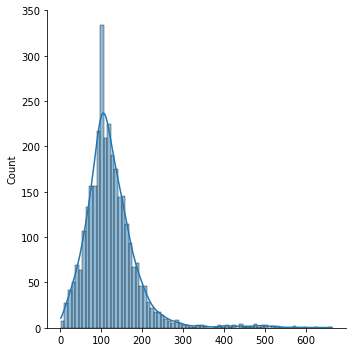

In [66]:
sns.displot(data_wire.loc[:, 'Wire 1':'Wire 9'].sum(axis=1),kde=True);

### Вывод:
- data_arc - суммарные значения активной и реактивной мощности имеют нормальный закон распределения, в данных имеются выбросы, есть сильная положительная корреляция между столбцами active и reactive power, для построения прогноза необходимо оставить только один их них
- data_bulk - было найдено общее количество добавок, имеются выбросы, распределение близко к нормальному
- data_temp - были удалены строки, содержащие заглушки, найдена дельта м/у нч и кон температурами, в данных имеются выбросы (кон температрура 1700, дельта около 400), распределение кон температуры близко к нормальному
- data_gas - имеются выбросы, распределение нормальное
- data_wire - имеются выбросы, распределение нормальное

### Предобработка данных

In [67]:
data_all = data_arc_grouped.drop(['reactive_power'],axis=1)

In [68]:
data_all = (data_all.merge(data_temp_joined[['key','temperature_y','delta','time']], on = 'key', how='inner')
 .merge(data_bulk, on = 'key', how='inner')
 .merge(data_gas[['key','gas']],on = 'key', how='inner')
 .merge(data_wire, on = 'key', how='inner')          
)


In [69]:
data_all = data_all.rename( 
 columns={ 
    'temperature_y':'temperature'
 } 
)

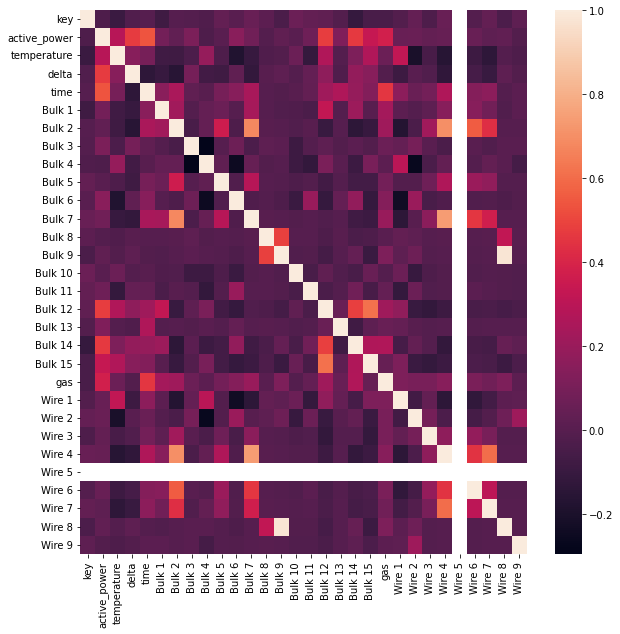

In [70]:
corr=data_all.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr);

In [71]:
data_all['Wire 8'].corr(data_all['Bulk 9'])

0.9749686403984983

### Построение моделей

In [177]:
#'key' не не может быть использован, т.к. не несет никакой информации и 'Bulk 9' т.к. имеет высокий коэф корреляции
new_data = data_all.drop(['key','Bulk 9','Wire 5', 'Wire 8', 'Bulk 8','Wire 9', 'Bulk 5', 'Bulk 10'], axis=1) 

In [178]:
train,test = train_test_split(new_data, test_size=0.2, random_state=12092022)

In [179]:
#удвление выбросов 
train = train.query('active_power<20 & delta<100')

In [180]:
X_train=train.drop(['temperature'], axis=1)
y_train=train['temperature']
X_test=test.drop(['temperature'], axis=1)
y_test=test['temperature']

In [181]:
X_train.shape, X_test.shape

((1860, 21), (466, 21))

In [182]:
lin_reg = LinearRegression()

In [183]:
cross_val_score(lin_reg, X_train, y_train, cv=5, scoring = 'neg_median_absolute_error').mean()

-5.578844192804581

In [184]:
xgb = xg.XGBRegressor()

In [185]:
params ={'learning_rate': [0.05, 0.1, 0.15, 0.2],
        'max_depth': [5,10,15,20],
        'n_estimators': [10, 50, 500, 1000],
         'random_state': [12092022],
         'colsample_bytree': [0.3, 0.5, 0.7]
        }

In [186]:
grid = GridSearchCV(xgb, param_grid=params, scoring='neg_median_absolute_error', cv=5);
grid.fit(X_train, y_train);

In [187]:
grid.best_score_

-5.03612060546875

In [188]:
grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.15,
 'max_depth': 5,
 'n_estimators': 50,
 'random_state': 12092022}

In [189]:
importances =  grid.best_estimator_.feature_importances_
features = list(X_train.columns)
feature_results = pd.DataFrame({'feature': features,'importance': importances}).sort_values('importance',ascending = False)

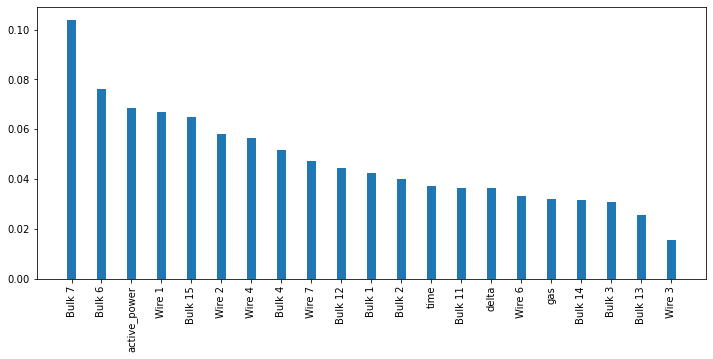

In [190]:
plt.figure(figsize=(12,5))
plt.bar(feature_results['feature'], feature_results['importance'], width=0.3);
plt.xticks(rotation='vertical')
plt.show()

### Тестирование лучшей моделей

In [191]:
#т.к. на кросс валидации лучше себя показала модель XGBRegressor, она будет использована для оценки тестовых данных 
mean_absolute_error(y_test, grid.predict(X_test))

6.478139983737929

### Вывод:
- были выделены обуч и тест выборки в соотношении 4:1
- из обуч выборки были удалены выбросы по столбцам active_time и delta
- были удалены параметры 'Wire 9','Bulk 8','Wire 5', т.к. их вклад составлял < 0.02
- Была обучена модель линейной регрессиии, среднее значение МАЕ на кросс валидации -5.58
- была обучена модель  XGBRegressor, лучшее значение МАЕ при подборе параметров  -5.04
- была выбрана модель XGBRegressor, так как показала лучший результат на обуч датасете
- значение МАЕ на валидационной выборке 6.47